In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/loan-preprocessed/loan-processed.csv


In [2]:
loan = pd.read_csv('/kaggle/input/loan-preprocessed/loan-processed.csv')

In [4]:
loan.shape

(37544, 35)

In [5]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37544 entries, 0 to 37543
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   loan_amnt                 37544 non-null  int64  
 1   funded_amnt               37544 non-null  int64  
 2   funded_amnt_inv           37544 non-null  float64
 3   term                      37544 non-null  object 
 4   int_rate                  37544 non-null  float64
 5   installment               37544 non-null  float64
 6   grade                     37544 non-null  object 
 7   sub_grade                 37544 non-null  object 
 8   emp_length                37544 non-null  int64  
 9   home_ownership            37544 non-null  object 
 10  annual_inc                37544 non-null  float64
 11  verification_status       37544 non-null  object 
 12  purpose                   37544 non-null  object 
 13  dti                       37544 non-null  float64
 14  delinq

In [6]:
loan.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,chargeoff_within_12_mths,pub_rec_bankruptcies,tax_liens,isd_month,isd_year,loan_status
0,5000,5000,4975.0,36 months,10.65,162.87,B,B2,10,RENT,...,0.00,0.00,0.00,171.62,0.0,0.0,0.0,12,2011,Fully Paid
1,2500,2500,2500.0,60 months,15.27,59.83,C,C4,1,RENT,...,0.00,117.08,1.11,119.66,0.0,0.0,0.0,12,2011,Charged Off
2,2400,2400,2400.0,36 months,15.96,84.33,C,C5,10,RENT,...,0.00,0.00,0.00,649.91,0.0,0.0,0.0,12,2011,Fully Paid
3,10000,10000,10000.0,36 months,13.49,339.31,C,C1,10,RENT,...,16.97,0.00,0.00,357.48,0.0,0.0,0.0,12,2011,Fully Paid
4,5000,5000,5000.0,36 months,7.90,156.46,A,A4,3,RENT,...,0.00,0.00,0.00,161.03,0.0,0.0,0.0,12,2011,Fully Paid


In [7]:
cols_with_nulls = []
for i in loan.columns:
    if loan[i].isna().sum() > 0:
        cols_with_nulls.append(i)
print(cols_with_nulls)

['revol_util', 'chargeoff_within_12_mths', 'pub_rec_bankruptcies', 'tax_liens']


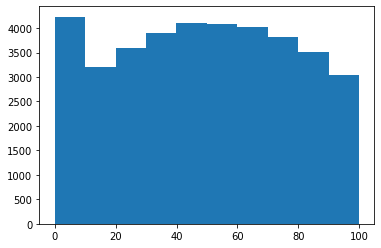

In [9]:
import matplotlib.pyplot as plt
plt.hist(loan['revol_util'])
plt.show()

In [10]:
median_ru = loan['revol_util'].median()
loan['revol_util'] = loan['revol_util'].fillna(median_ru)

In [11]:
loan.drop("chargeoff_within_12_mths",axis=1, inplace=True)

In [12]:
loan['pub_rec_bankruptcies'].fillna(0, inplace=True)

In [13]:
loan.drop("tax_liens",axis=1,inplace=True)

In [14]:
loan['term'] = loan['term'].map({' 36 months':36,' 60 months':60})

In [16]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
loan["grade"] = le.fit_transform(loan['grade'])

In [18]:
x = loan.drop("loan_status",axis=1)
y = loan['loan_status']

In [19]:
x = pd.get_dummies(x)

In [20]:
x.shape

(37544, 85)

In [23]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train , y_test = train_test_split(x,y,
                                                    test_size=0.2,random_state=42, stratify=y)

In [24]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
rf = RandomForestClassifier(max_depth = 16, n_estimators=150)
base = DecisionTreeClassifier()
bg = BaggingClassifier(base_estimator=base , n_estimators=50)

In [26]:
from sklearn.model_selection import cross_val_score
def trainer(model, x_train, y_train):
    model.fit(x_train,y_train)
    return model

def cross_val_scorer(trained_model,x,y,folds = 5):
    cvs = cross_val_score(trained_model, x, y, scoring='accuracy', cv = folds)
    return {'model':trained_model, 'Cross validated score':cvs.mean()}

In [27]:
models  = [dt,rf,bg]
for i in models:
    print(cross_val_scorer(trainer(i,x_train,y_train),x,y))

{'model': DecisionTreeClassifier(), 'Cross validated score': 0.986068878595907}
{'model': RandomForestClassifier(max_depth=16, n_estimators=150), 'Cross validated score': 0.9936340004142072}
{'model': BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=50), 'Cross validated score': 0.9954984971683419}


In [28]:
x.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'emp_length', 'annual_inc', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt', 'pub_rec_bankruptcies',
       'isd_month', 'isd_year', 'sub_grade_A1', 'sub_grade_A2', 'sub_grade_A3',
       'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1', 'sub_grade_B2',
       'sub_grade_B3', 'sub_grade_B4', 'sub_grade_B5', 'sub_grade_C1',
       'sub_grade_C2', 'sub_grade_C3', 'sub_grade_C4', 'sub_grade_C5',
       'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3', 'sub_grade_D4',
       'sub_grade_D5', 'sub_grade_E1', 'sub_grade_E2', 'sub_grade_E3',
       'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F1', 'sub_grade_F2',
       'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5',

In [30]:
numerical_cols = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'emp_length', 'annual_inc', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt', 'pub_rec_bankruptcies']

In [40]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_scaled = x
x_scaled[numerical_cols] = sc.fit_transform(x_scaled[numerical_cols])


In [41]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
x_scaled_train, x_scaled_test, y_train , y_test = train_test_split(x_scaled,y,
                                                    test_size=0.2,random_state=42, stratify=y)

In [42]:
lr = LogisticRegression(random_state=42)
knn10 = KNeighborsClassifier(n_neighbors=10)
knn15 = KNeighborsClassifier(n_neighbors=15)
knn20 = KNeighborsClassifier(n_neighbors=20)
sv = SVC(random_state=42)

In [43]:
models = [lr,knn10,knn15,knn20,sv]
for i in models:
    print(cross_val_scorer(trainer(i,x_scaled_train,y_train),x,y))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


{'model': LogisticRegression(random_state=42), 'Cross validated score': 0.9841517545310394}
{'model': KNeighborsClassifier(n_neighbors=10), 'Cross validated score': 0.9011821332071556}
{'model': KNeighborsClassifier(n_neighbors=15), 'Cross validated score': 0.8981456704095026}
{'model': KNeighborsClassifier(n_neighbors=20), 'Cross validated score': 0.8987316126348966}
{'model': SVC(random_state=42), 'Cross validated score': 0.856195399830273}
